# Geographic Correlation and Oceanic Tools

##### Keywords: normal distribution, multivariate normal, oceanic tools, correlation, covariance,  posterior, posterior predictive, gaussian process, poisson regression

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

##### Data: data/Kline2.csv, data/distmatrix.csv

## Reading in our data

We read back the Oceanic tools data

In [2]:
df = pd.read_csv("data/Kline2.csv", sep=';')
df.head()

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235


And center it

In [3]:
df['logpop_c'] = df.logpop - df.logpop.mean()

In [4]:
df.head()

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop,logpop_c
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065,-1.973939
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220,-1.663784
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689,-0.788316
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494,-0.502510
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235,-0.067769


And read in the distance matrix

In [6]:
dfd = pd.read_csv("data/distmatrix.csv", header=None)
dij=dfd.values
dij

array([[ 0.   ,  0.475,  0.631,  4.363,  1.234,  2.036,  3.178,  2.794,
         1.86 ,  5.678],
       [ 0.475,  0.   ,  0.315,  4.173,  1.236,  2.007,  2.877,  2.67 ,
         1.965,  5.283],
       [ 0.631,  0.315,  0.   ,  3.859,  1.55 ,  1.708,  2.588,  2.356,
         2.279,  5.401],
       [ 4.363,  4.173,  3.859,  0.   ,  5.391,  2.462,  1.555,  1.616,
         6.136,  7.178],
       [ 1.234,  1.236,  1.55 ,  5.391,  0.   ,  3.219,  4.027,  3.906,
         0.763,  4.884],
       [ 2.036,  2.007,  1.708,  2.462,  3.219,  0.   ,  1.801,  0.85 ,
         3.893,  6.653],
       [ 3.178,  2.877,  2.588,  1.555,  4.027,  1.801,  0.   ,  1.213,
         4.789,  5.787],
       [ 2.794,  2.67 ,  2.356,  1.616,  3.906,  0.85 ,  1.213,  0.   ,
         4.622,  6.722],
       [ 1.86 ,  1.965,  2.279,  6.136,  0.763,  3.893,  4.789,  4.622,
         0.   ,  5.037],
       [ 5.678,  5.283,  5.401,  7.178,  4.884,  6.653,  5.787,  6.722,
         5.037,  0.   ]])

## Implementing the simple tools:logpop model and varying intercepts models

In [7]:
import theano.tensor as tt

In [16]:
import theano.tensor as t
with pm.Model() as m2c_onlyp:
    betap = pm.Normal("betap", 0, 1)
    alpha = pm.Normal("alpha", 0, 10)
    loglam = alpha + betap*df.logpop_c
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    trace2c_onlyp = pm.sample(6000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betap]
100%|██████████| 7000/7000 [00:05<00:00, 1374.78it/s]


In [17]:
pm.summary(trace2c_onlyp)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betap,0.239422,0.031505,0.000286,0.178178,0.301947,10383.0,0.999918
alpha,3.478431,0.057299,0.000577,3.366003,3.587042,10055.0,0.999939


Notice that $\beta_P$ has a value around 0.24

We also implement the varying intercepts per society model from before

In [20]:
with pm.Model() as m3c:
    betap = pm.Normal("betap", 0, 1)
    alpha = pm.Normal("alpha", 0, 10)
    sigmasoc = pm.HalfCauchy("sigmasoc", 1)
    alphasoc = pm.Normal("alphasoc", 0, sigmasoc, shape=df.shape[0])
    loglam = alpha + alphasoc + betap*df.logpop_c 
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
with m3c:
    trace3 = pm.sample(6000, tune=1000, nuts_kwargs=dict(target_accept=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alphasoc, sigmasoc_log__, alpha, betap]
100%|██████████| 7000/7000 [00:28<00:00, 247.87it/s]
The number of effective samples is smaller than 25% for some parameters.


In [21]:
pm.summary(trace3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betap,0.258089,0.082296,0.001338,0.096656,0.424239,4166.0,0.999973
alpha,3.446465,0.120746,0.002027,3.199103,3.687472,3653.0,0.999921
alphasoc__0,-0.209619,0.247940,0.003688,-0.718741,0.259506,4968.0,1.000043
alphasoc__1,0.038430,0.219664,0.002941,-0.404914,0.487200,5961.0,0.999917
alphasoc__2,-0.050901,0.195434,0.002468,-0.447657,0.339753,5818.0,0.999921
alphasoc__3,0.324157,0.189557,0.002763,-0.031798,0.699002,4321.0,0.999929
alphasoc__4,0.039406,0.175986,0.002227,-0.301135,0.401451,6167.0,1.000062
alphasoc__5,-0.320429,0.208348,0.003087,-0.733230,0.055638,4967.0,0.999927
alphasoc__6,0.144230,0.172236,0.002496,-0.168542,0.513625,5458.0,0.999972
alphasoc__7,-0.174227,0.184070,0.002252,-0.568739,0.162993,6696.0,0.999919


## A model with a custom covariance matrix

The assumption here now is that the intercepts for these various societies are correlated...

We use a custom covariance matrix which inverse-square weights distance

![](images/covgp.png)

You have seen this before! This is an example of a Gaussian Process Covariance Matrix. 

Here is the complete model:

![](images/modelgp.png)

In [22]:
with pm.Model() as mgc:
    betap = pm.Normal("betap", 0, 1)
    alpha = pm.Normal("alpha", 0, 10)
    etasq = pm.HalfCauchy("etasq", 1)
    rhosq = pm.HalfCauchy("rhosq", 1)
    means=tt.stack([0.0]*10)
    sigma_matrix = tt.nlinalg.diag([0.01]*10)
    cov=tt.exp(-rhosq*dij*dij)*etasq + sigma_matrix
    gammasoc = pm.MvNormal("gammasoc", means, cov=cov, shape=df.shape[0])
    loglam = alpha + gammasoc + betap*df.logpop_c 
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)

In [23]:
with mgc:
    mgctrace = pm.sample(10000, tune=2000, nuts_kwargs=dict(target_accept=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gammasoc, rhosq_log__, etasq_log__, alpha, betap]
100%|██████████| 12000/12000 [05:11<00:00, 38.58it/s]
The acceptance probability does not match the target. It is 0.895944134094, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
pm.summary(mgctrace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betap,0.247414,0.116188,0.001554,0.005191,0.474834,5471.0,1.000157
alpha,3.512649,0.357406,0.007140,2.790415,4.239959,2111.0,1.001964
gammasoc__0,-0.269862,0.455632,0.008620,-1.239333,0.607492,2569.0,1.001484
gammasoc__1,-0.117755,0.445192,0.008520,-1.041095,0.757448,2439.0,1.001758
gammasoc__2,-0.165474,0.430544,0.008116,-1.042846,0.686170,2406.0,1.001881
gammasoc__3,0.299581,0.387140,0.007481,-0.481745,1.079855,2365.0,1.001936
gammasoc__4,0.026350,0.382587,0.007425,-0.763338,0.770842,2292.0,1.001728
gammasoc__5,-0.458827,0.389807,0.006976,-1.286453,0.231992,2481.0,1.001517
gammasoc__6,0.097538,0.377499,0.007064,-0.653992,0.840048,2382.0,1.001464
gammasoc__7,-0.263660,0.378417,0.006917,-1.077743,0.404521,2407.0,1.001890


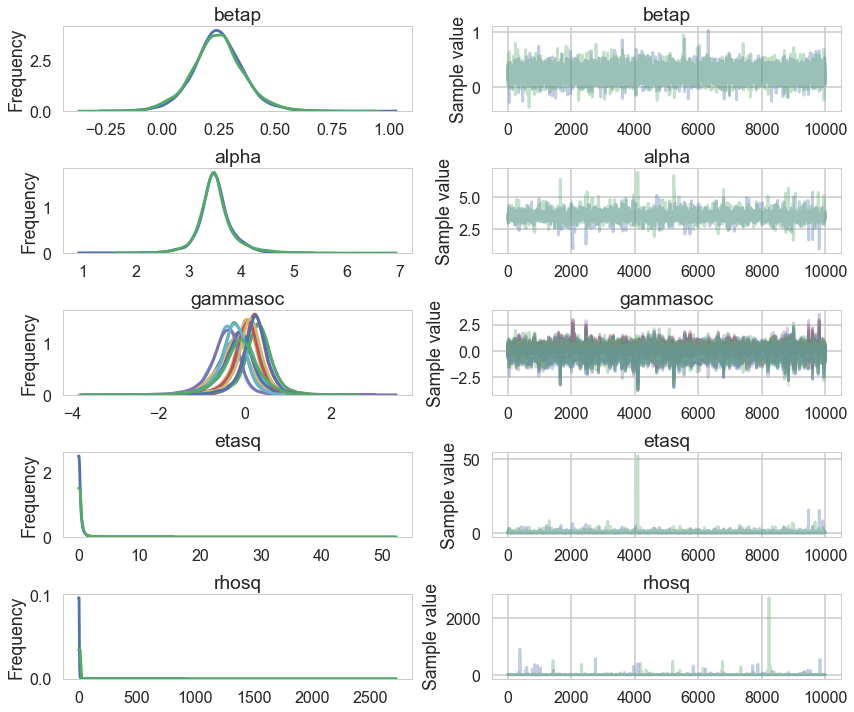

In [24]:
pm.traceplot(mgctrace);

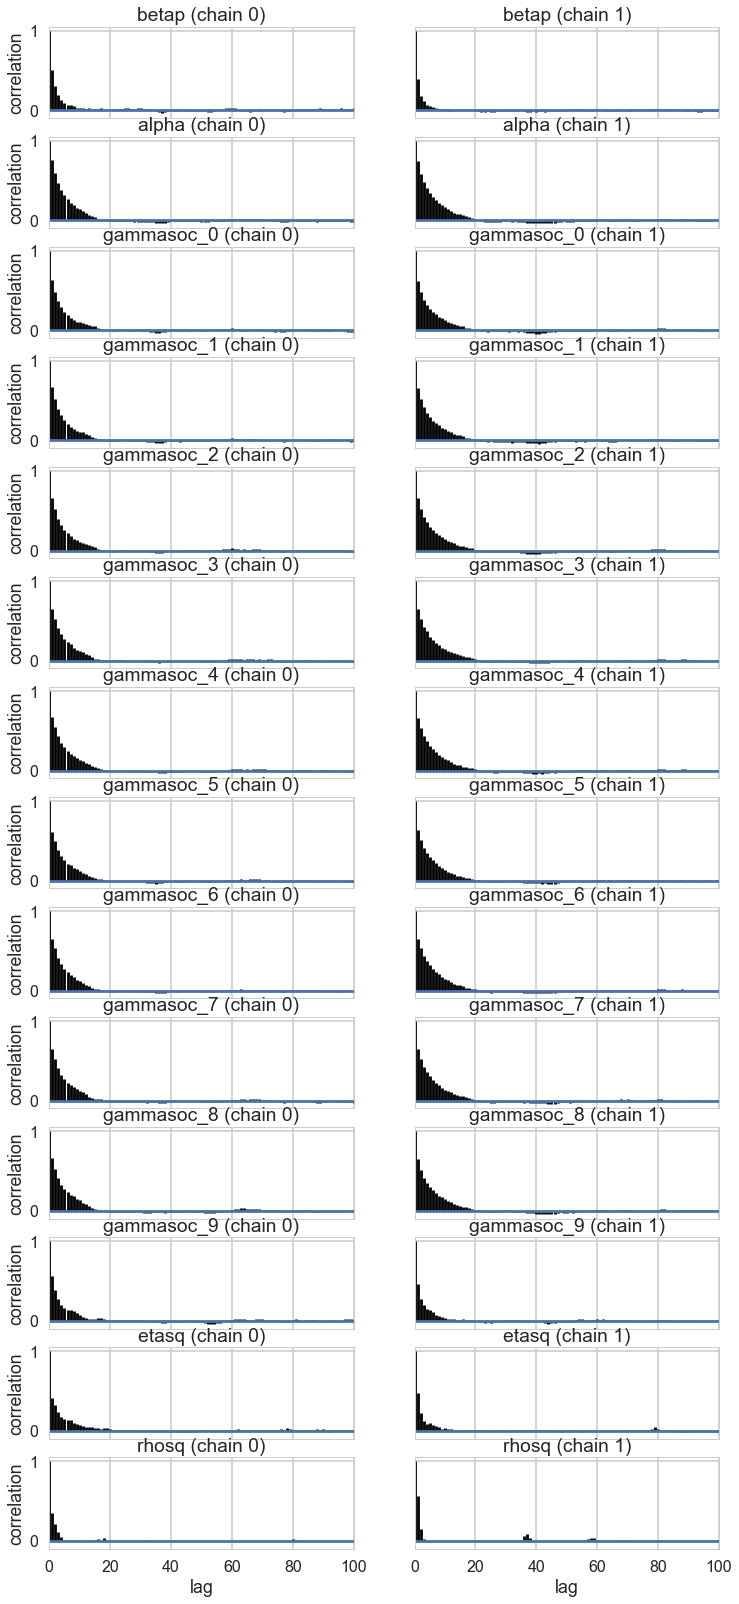

In [26]:
pm.autocorrplot(mgctrace);

In [27]:
d={}
for i, v in enumerate(df.culture.values):
    d[v] = mgctrace['gammasoc'][:,i]
dfsamps=pd.DataFrame.from_dict(d)
dfsamps.head()

,Chuuk,Hawaii,Lau Fiji,Malekula,Manus,Santa Cruz,Tikopia,Tonga,Trobriand,Yap
0,0.282612,0.059503,0.145726,-0.024485,-0.283392,-0.064665,0.211578,0.421679,-0.337896,0.552060
1,0.138628,-0.023895,0.202573,0.083340,-0.147399,0.037469,0.259075,0.432713,-0.513998,0.579821
2,0.257026,0.065751,0.263479,-0.175381,-0.196812,-0.139182,-0.060890,0.358894,-0.478396,0.349795
3,0.138580,-0.494443,0.124155,0.065190,-0.183672,0.130431,0.207621,0.186890,-0.280590,0.541165
4,0.034011,0.036418,0.224733,-0.600040,-0.405896,-0.531054,-0.348027,0.026920,-0.589172,0.220345


In [28]:
dfsamps.describe()

,Chuuk,Hawaii,Lau Fiji,Malekula,Manus,Santa Cruz,Tikopia,Tonga,Trobriand,Yap
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.097538,-0.123068,0.026350,-0.269862,-0.263660,-0.165474,-0.117755,0.233544,-0.458827,0.299581
std,0.377509,0.473743,0.382597,0.455644,0.378426,0.430555,0.445203,0.361625,0.389816,0.387149
min,-3.359014,-3.773198,-3.389680,-3.856332,-3.592680,-3.704032,-3.634145,-3.229867,-3.808333,-3.046678
25%,-0.080201,-0.369415,-0.156227,-0.507103,-0.444126,-0.377180,-0.344367,0.064836,-0.650613,0.107982
50%,0.108659,-0.112151,0.039389,-0.242684,-0.244814,-0.140033,-0.098324,0.241970,-0.429267,0.304480
75%,0.287604,0.132445,0.220311,-0.015149,-0.057941,0.070862,0.129670,0.415369,-0.233960,0.500363
max,2.908532,3.523802,2.684128,2.373157,2.501715,2.561251,2.619592,3.046274,2.093728,3.017744


## Plotting posteriors and predictives

Lets plot the covariance posteriors for the 100 random samples in the trace.

In [42]:
smalleta=np.random.choice(mgctrace['etasq'], replace=False, size=100)
smallrho=np.random.choice(mgctrace['rhosq'], replace=False, size=100)

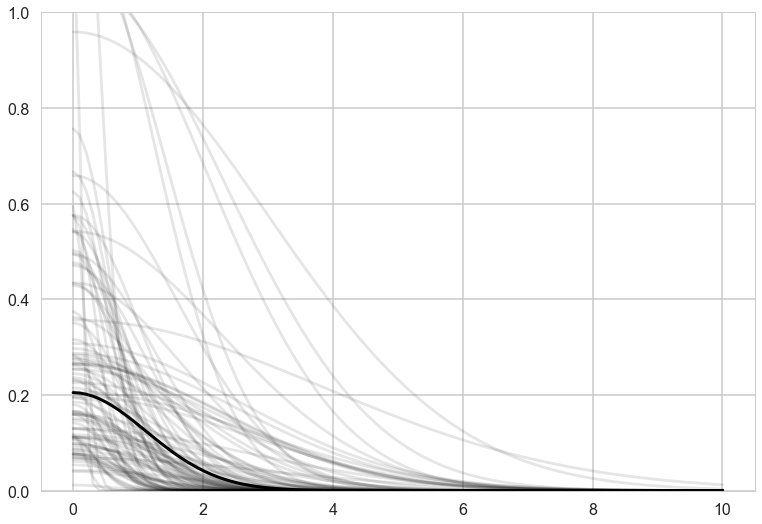

In [55]:
with sns.plotting_context('poster'):
    d=np.linspace(0,10,100)
    for i in range(100):
        covarod = lambda d: smalleta[i]*np.exp(-smallrho[i]*d*d)
        plt.plot(d, covarod(d),alpha=0.1, color='k')
    medetasq=np.median(mgctrace['etasq'])
    medrhosq=np.median(mgctrace['rhosq'])
    covarodmed = lambda d: medetasq*np.exp(-medrhosq*d*d)
    plt.plot(d, covarodmed(d),alpha=1.0, color='k', lw=3)
    plt.ylim([0,1]); 

The x-axis is thousands of kilometers. Notice how almost everything damps out by 4000 kms. Lets calculate the median correlation matrix:

In [43]:
medkij = np.diag([0.01]*10)+medetasq*(np.exp(-medrhosq*dij*dij))

In [44]:
#from statsmodels
def cov2corr(cov, return_std=False):
    '''convert covariance matrix to correlation matrix

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_std : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that division is defined elementwise. np.ma.array and np.matrix are allowed.

    '''
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    if return_std:
        return corr, std_
    else:
        return corr

In [45]:
medcorrij=cov2corr(medkij)
medcorrij

array([[  1.00000000e+00,   8.71785980e-01,   8.14096714e-01,
          4.99776683e-04,   5.21038310e-01,   1.84041573e-01,
          1.73288749e-02,   4.30502586e-02,   2.41593313e-01,
          2.65025654e-06],
       [  8.71785980e-01,   1.00000000e+00,   9.16627626e-01,
          9.51206322e-04,   5.20017938e-01,   1.92806478e-01,
          3.57157022e-02,   5.63298362e-02,   2.06001853e-01,
          1.47715424e-05],
       [  8.14096714e-01,   9.16627626e-01,   1.00000000e+00,
          2.58767794e-03,   3.67501866e-01,   2.99604292e-01,
          6.68407750e-02,   1.05368392e-01,   1.21399142e-01,
          8.95698536e-06],
       [  4.99776683e-04,   9.51206322e-04,   2.58767794e-03,
          1.00000000e+00,   9.34889296e-06,   8.60394889e-02,
          3.65244813e-01,   3.38258916e-01,   3.09612981e-07,
          1.25890327e-09],
       [  5.21038310e-01,   5.20017938e-01,   3.67501866e-01,
          9.34889296e-06,   1.00000000e+00,   1.56160443e-02,
          1.52965471e-03

We'll data frame it to see clearly

In [46]:
dfcorr = pd.DataFrame(medcorrij*100).set_index(df.culture.values)
dfcorr.columns = df.culture.values
dfcorr

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,100.000000,87.178598,81.409671,4.997767e-02,52.103831,18.404157,1.732887,4.305026,24.159331,2.650257e-04
Tikopia,87.178598,100.000000,91.662763,9.512063e-02,52.001794,19.280648,3.571570,5.632984,20.600185,1.477154e-03
Santa Cruz,81.409671,91.662763,100.000000,2.587678e-01,36.750187,29.960429,6.684077,10.536839,12.139914,8.956985e-04
Yap,0.049978,0.095121,0.258768,1.000000e+02,0.000935,8.603949,36.524481,33.825892,0.000031,1.258903e-07
Lau Fiji,52.103831,52.001794,36.750187,9.348893e-04,100.000000,1.561604,0.152965,0.223880,75.677208,7.387935e-03
Trobriand,18.404157,19.280648,29.960429,8.603949e+00,1.561604,100.000000,26.321398,71.578279,0.233071,2.245740e-06
Chuuk,1.732887,3.571570,6.684077,3.652448e+01,0.152965,26.321398,100.000000,53.177192,0.010639,1.614077e-04
Manus,4.305026,5.632984,10.536839,3.382589e+01,0.223880,71.578279,53.177192,100.000000,0.019849,1.557100e-06
Tonga,24.159331,20.600185,12.139914,3.096130e-05,75.677208,0.233071,0.010639,0.019849,100.000000,4.045149e-03
Hawaii,0.000265,0.001477,0.000896,1.258903e-07,0.007388,0.000002,0.000161,0.000002,0.004045,1.000000e+02


Notice how there is correlation in the upper left and with Manus and Trobriand. Mcelreath has a distance plot i reproduce below:

![](images/pacisl.png)

To produce a plot like the one on the right, we calculate the posterior predictives with the correlation free part of the model and then overlay the correlations

In [47]:
from scipy.stats import poisson
def compute_pp_no_corr(lpgrid, trace, contact=0):
    alphatrace = trace['alpha']
    betaptrace = trace['betap']
    tl=len(trace)
    gl=lpgrid.shape[0]
    lam = np.empty((gl, 2*tl))
    lpgrid = lpgrid - lpgrid.mean()
    for i, v in enumerate(lpgrid):
        temp = alphatrace + betaptrace*lpgrid[i]
        lam[i,:] = poisson.rvs(np.exp(temp))
    return lam

In [48]:
lpgrid = np.linspace(6,13,30)
pp = compute_pp_no_corr(lpgrid, mgctrace)
ppmed = np.median(pp, axis=1)
pphpd = pm.stats.hpd(pp.T)

In [49]:
import itertools
corrs={}
for i, j in itertools.product(range(10), range(10)):
    if i <j:
        corrs[(i,j)]=medcorrij[i,j]
corrs

{(0, 1): 0.87178598035086485,
 (0, 2): 0.81409671378956938,
 (0, 3): 0.00049977668270061984,
 (0, 4): 0.52103830967748688,
 (0, 5): 0.18404157314186861,
 (0, 6): 0.017328874910928813,
 (0, 7): 0.04305025856741021,
 (0, 8): 0.241593313072233,
 (0, 9): 2.6502565440185815e-06,
 (1, 2): 0.9166276258652174,
 (1, 3): 0.00095120632192379471,
 (1, 4): 0.5200179376567835,
 (1, 5): 0.19280647828541175,
 (1, 6): 0.035715702211517139,
 (1, 7): 0.05632983623575849,
 (1, 8): 0.20600185316804365,
 (1, 9): 1.4771542363619412e-05,
 (2, 3): 0.0025876779443579313,
 (2, 4): 0.36750186564264986,
 (2, 5): 0.29960429169647806,
 (2, 6): 0.066840774961541019,
 (2, 7): 0.10536839180821188,
 (2, 8): 0.12139914234488278,
 (2, 9): 8.9569853640368644e-06,
 (3, 4): 9.348892959453282e-06,
 (3, 5): 0.086039488876625755,
 (3, 6): 0.36524481329909764,
 (3, 7): 0.33825891559247928,
 (3, 8): 3.0961298086947269e-07,
 (3, 9): 1.2589032666550904e-09,
 (4, 5): 0.01561604425648749,
 (4, 6): 0.0015296547115497437,
 (4, 7): 0.00

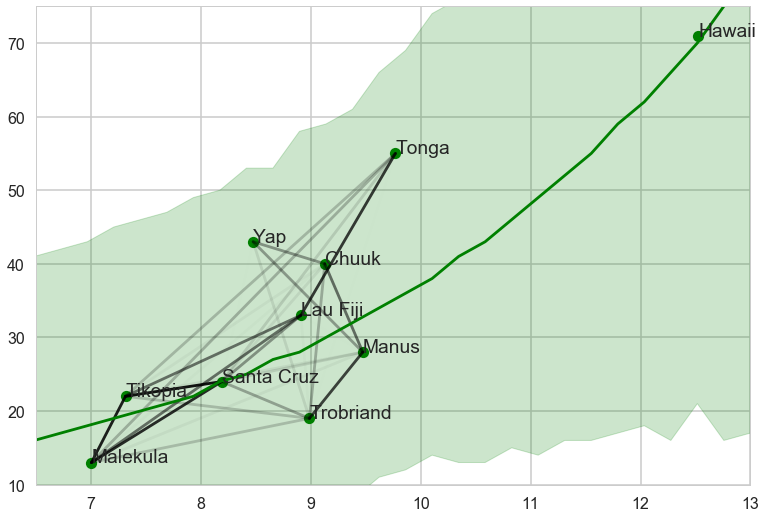

In [54]:
with sns.plotting_context('poster'):
    plt.plot(df.logpop, df.total_tools,'o', color="g")
    lpv = df.logpop.values
    ttv = df.total_tools.values
    for a,x,y in zip(df.culture.values, lpv, ttv):
        plt.annotate(a, xy=(x,y))
    for i in range(10):
        for j in range(10):
            if i < j:
                plt.plot([lpv[i],lpv[j]],[ttv[i], ttv[j]],'k', alpha=corrs[(i,j)]/1.)
    plt.plot(lpgrid, ppmed, color="g")
    plt.fill_between(lpgrid, pphpd[:,0], pphpd[:,1], color="g", alpha=0.2, lw=1)
    plt.ylim([10, 75])
    plt.xlim([6.5, 13])

Notice how distance probably pulls Fiji up from the median, and how Manus and Trobriand are below the median but highly correlated. A smaller effect can be seen with the triangle on the left. Of-course, causality is uncertain